In [1]:
import os, json, sys
sys.path.append('../..')

In [2]:
import os.path
import numpy as np
import os
import sklearn.model_selection

In [3]:
import sklearn

import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from pprint import pprint

In [4]:
from matplotlib import pyplot as plt
from pprint import pprint

In [5]:
path_ = '/media/tiagobotari/tiagobotari/data/text/rt-polaritydata/rt-polaritydata'
def load_polarity(path=path_):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            data.append(line.decode('utf8', errors='ignore').strip())
            labels.append(l)
    return data, labels

In [6]:
x, y = load_polarity()
x_train_all, x_test, y_train_all, y_test = train_test_split(
    x, y, test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=.1, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [7]:
len(x)

10662

In [8]:
class VectorizeText():
        def __init__(self):
            self.count_vect = CountVectorizer()
            self.tf_transformer = TfidfTransformer(use_idf=False)
        def fit(self, x):
            x = self.count_vect.fit_transform(x)
            self.tf_transformer.fit(x)
        def transform(self, x):
            x = self.count_vect.transform(x)
            x = self.tf_transformer.transform(x)
            return x     

In [9]:
vect_text = VectorizeText()
vect_text.fit(x_train)    
x_vec_train = vect_text.transform(x_train)

# Train Model
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x_vec_train, y_train)

def MNB_predict(texts):
    return clf.predict(vect_text.transform(texts))
def MNB_predict_prob(texts):
    return clf.predict_proba(vect_text.transform(texts))

preds = MNB_predict(x_val)
print('Val accuracy', sklearn.metrics.accuracy_score(y_val, preds))


Val accuracy 0.7584994138335287


# Explanation

In [10]:
from m_lime.densities.density_word2vec import DensityWord2Vec

In [11]:
density = DensityWord2Vec(x_train_all)
print('Training Error:', density.manifold.loss_training)

Training Error: 2086352.875


In [12]:
from m_lime.explainers.statistics import ExplainStatistics

In [13]:
print('Similarities')
pprint(density.manifold.get_similar_words('the', n_sample=10))

Similarities
[('its', 0.9996041655540466),
 ('a', 0.9994431138038635),
 ('his', 0.9993776082992554),
 ('one', 0.9993262887001038),
 ('most', 0.9992437958717346),
 ('kind', 0.9991545677185059),
 ('lots', 0.9991410970687866),
 (',', 0.9991320967674255),
 ('sense', 0.9990931749343872),
 ('all', 0.9990618228912354)]


In [14]:
print('Test:')
x_explain = [x_test[1]]
print(x_explain)
print('predicted - true')
print(MNB_predict(x_explain), 1)
print(MNB_predict_prob(x_explain), 1)

Test:
["the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."]
predicted - true
[1] 1
[[0.29029215 0.70970785]] 1


In [15]:
explainer = ExplainStatistics(model_predict=MNB_predict_prob, density=density)

In [16]:
density.generated_data = None
x_explain = x_explain
samples = density.sample_radius(x_explain, r=None, n_samples=2000, random_state=None)

In [17]:
x_explain

["the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."]

In [18]:
from pprint import pprint
features_names=[f'{e}: {word}' for e, word in enumerate(x_explain[0].split())]

explanation, con_fav_samples = explainer.explain_instance(
    x_explain=x_explain,
    class_index=1,
    features_names=features_names,
    n_samples=200,
    tol=0.001)

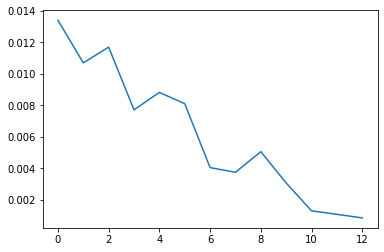

In [19]:
x = range(0, len(explainer.local_model.convergence_diffs))
y = explainer.local_model.convergence_diffs
plt.plot(x[:], y[:])

In [20]:
means = explanation['importance']['mean']

In [21]:
from matplotlib import pyplot as plt

<BarContainer object of 14 artists>

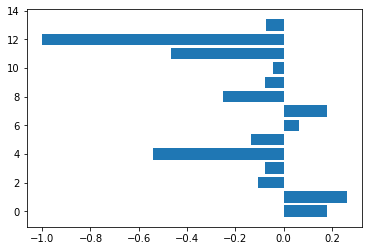

In [22]:
plt.barh([*means.keys()], [*means.values()])

In [23]:
x_explain

["the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."]

In [24]:
con_fav_samples.samples_fav

["the movie's thesis -- elegant technology for the masses -- is surprisingly ill-conceived .",
 "the movie's thesis -- ill-conceived technology for the masses -- is surprisingly refreshing .",
 "the movie's thesis -- elegant technology for the masses -- is surprisingly heavy-handed .",
 "the movie's thesis -- elegant technology for the masses -- is surprisingly dull .",
 "the movie's thesis -- elegant technology for the masses -- is ill-conceived refreshing ."]

In [25]:
con_fav_samples.samples_con

["the movie's thesis -- elegant technology for touching masses -- is surprisingly refreshing .",
 "touching movie's thesis -- elegant technology for the masses -- is surprisingly refreshing .",
 'the touching thesis -- elegant technology for the masses -- is surprisingly refreshing .',
 "the movie's thesis -- elegant technology for wonderful masses -- is surprisingly refreshing .",
 "wonderful movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."]